In [1]:
import numpy as np
import nibabel as nib
from scipy.signal import butter, filtfilt, hilbert
import matplotlib.pyplot as plt
%matplotlib inline
subjects = np.loadtxt('../100unrelatedsubjectsIDs.txt', dtype='str')
p = 116
K = 3
T = 1200

In [2]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype="bandpass")
    return b, a

# Apply Filter
# Changed by Anders to be correct range (from 0.01-0.1 to 0.009-0.08)
def butter_bandpass_filter(data, lowcut=0.009, highcut=0.08, fs=1 / 0.720, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [3]:
atlas = nib.load('../data/external/Schaefer2018_100Parcels_7Networks_order_Tian_Subcortex_S1.dlabel.nii')
atlas_data = atlas.get_fdata()
atlas_data = np.round(atlas_data)
atlas_data = atlas_data.astype(int)[0]
filtered_data_all = []

for sub in subjects[:10]:
    img = nib.load('../data/raw/'+sub+'/fMRI/rfMRI_REST1_RL_Atlas_MSMAll_hp2000_clean.dtseries.nii')
    data = img.get_fdata()
    data = data - np.mean(data, axis=0)

    GS = np.mean(data[:,:59412], axis=1)
    data = data - GS[:,None]*(data.T@GS).T/(GS.T@GS)
    
            # GS = mean(data(:,1:59412),2);
            # data = data-GS.*(data'*GS)'/(GS'*GS);
    # parcellate data in atlas
    parcellated_data = np.zeros((data.shape[0], atlas_data.max()))
    for i in range(1, atlas_data.max()+1):
        parcellated_data[:,i-1] = np.mean(data[:,atlas_data == i], axis=1)
    # filter data
    filtered_data = np.zeros(parcellated_data.shape)
    for i in range(p):
        filtered_data[:,i] = butter_bandpass_filter(parcellated_data[:,i])
    filtered_data_all.append(filtered_data)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


Set phase information equal to template phases, maintain existing amplitude information

In [4]:
ref1 = filtered_data_all[0][:400,0]
spec1 = np.fft.fft(ref1)
ref2 = filtered_data_all[0][400:800,38]
spec2 = np.fft.fft(ref2)
ref3 = filtered_data_all[0][800:,76]
spec3 = np.fft.fft(ref3)

phase_reset_data_all = []
for sub in range(10):
    newdata = np.zeros((T,p))
    for window in range(3):
            if window==0:
                for i in range(p):
                    signal_spec = np.fft.fft(filtered_data_all[sub][:400,i])
                    if i<38:
                        tmp = np.abs(signal_spec) * np.exp(1j*(np.angle(spec1)))
                    else:
                        tmp = np.abs(signal_spec) * np.exp(1j*np.random.rand()*2*np.pi)
                    newdata[:400,i] = np.real(np.fft.ifft(tmp))
            elif window == 1:
                for i in range(p):
                    signal_spec = np.fft.fft(filtered_data_all[sub][400:800,i])
                    if i<76 and i>=38:
                        tmp = np.abs(signal_spec) * np.exp(1j*(np.angle(spec2)))
                    else:
                        tmp = np.abs(signal_spec) * np.exp(1j*np.random.rand()*2*np.pi)
                    newdata[400:800,i] = np.real(np.fft.ifft(tmp))
            elif window == 2:
                for i in range(p):
                    signal_spec = np.fft.fft(filtered_data_all[sub][800:,i])
                    if i>=76:
                        tmp = np.abs(signal_spec) * np.exp(1j*(np.angle(spec3)))
                    else:
                        tmp = np.abs(signal_spec) * np.exp(1j*np.random.rand()*2*np.pi)
                    newdata[800:,i] = np.real(np.fft.ifft(tmp))
    phase_reset_data_all.append(newdata)

Calculate LEiDA

In [5]:
U_all = []
S_all = []
for sub in range(10):
    phases = np.zeros((filtered_data_all[sub].shape[0], p))
    for i in range(p):
        phases[:,i] = np.angle(hilbert(phase_reset_data_all[sub][:,i]))
    U_all_sub = np.zeros((T,p,2))
    S_all_sub = np.zeros((T,2))
    for t in range(T):
        c = np.cos(phases[t])
        s = np.sin(phases[t])
        U,S,_ = np.linalg.svd(np.c_[c,s], full_matrices=False)
        U_all_sub[t] = U
        S_all_sub[t] = S
    U_all.append(U_all_sub)
    S_all.append(S_all_sub)
U_tmp = np.concatenate(U_all, axis=0)

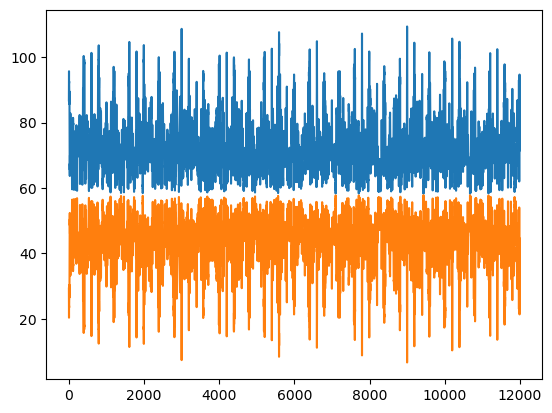

In [8]:
S_tmp = np.concatenate(S_all, axis=0)
plt.plot(S_tmp**2)

In [9]:
from src.DMM_EM.diametrical_clustering import diametrical_clustering, grassmannian_clustering_gruber2006
C_DC = diametrical_clustering(U_tmp[:,:,0],K=K)
C_GC = grassmannian_clustering_gruber2006(U_tmp,K=K)

In [10]:
sim_DC = np.zeros((U_tmp.shape[0],K))
sim_GC = np.zeros((U_tmp.shape[0],K))
for t in range(U_tmp.shape[0]):
    for c in range(K):
        sim_GC[t,c] = 1-np.linalg.norm(U_tmp[t]@U_tmp[t].T - C_GC[c]@C_GC[c].T)
        sim_DC[t,c] = (U_tmp[t,:,0] @ C_DC[:,c])**2

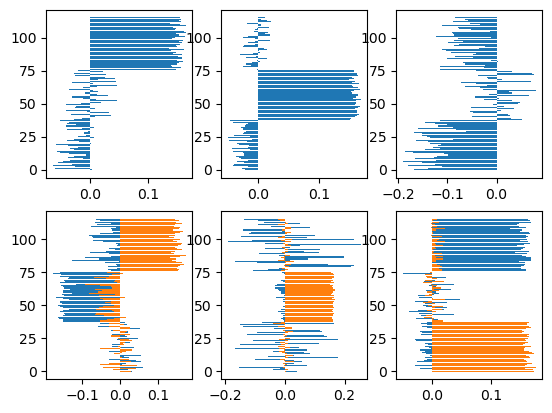

In [11]:
plt.subplot(2,3,1)
plt.barh(range(p),C_DC[:,0])
plt.subplot(2,3,2)
plt.barh(range(p),C_DC[:,1])
plt.subplot(2,3,3)
plt.barh(range(p),C_DC[:,2])
plt.subplot(2,3,4)
plt.barh(range(p),C_GC[0,:,0])
plt.barh(range(p),C_GC[0,:,1])
plt.subplot(2,3,5)
plt.barh(range(p),C_GC[1,:,0])
plt.barh(range(p),C_GC[1,:,1])
plt.subplot(2,3,6)
plt.barh(range(p),C_GC[2,:,0])
plt.barh(range(p),C_GC[2,:,1])
plt.show()

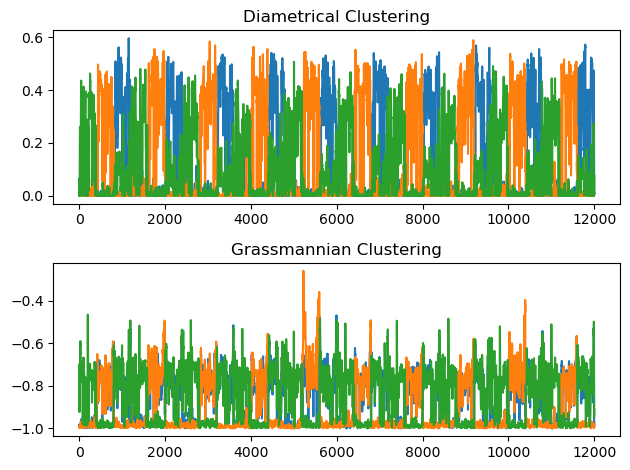

In [12]:
plt.subplot(2,1,1)
plt.plot(sim_DC)
plt.title('Diametrical Clustering')
plt.subplot(2,1,2)
plt.plot(sim_GC)
plt.title('Grassmannian Clustering')
plt.tight_layout()

In [7]:
# use h5py to save this data (U_all)
import h5py
with h5py.File('../data/synthetic/phase_controlled_116data.h5', 'w') as f:
    f.create_dataset("U", data=U_tmp)

In [10]:
S_all

[array([[9.26803369, 5.48667035],
        [9.43429723, 5.19557849],
        [9.21681215, 5.57228623],
        ...,
        [7.98873659, 7.22357859],
        [7.98711413, 7.22537251],
        [8.95170229, 5.98890858]]),
 array([[9.32810665, 5.38390438],
        [9.26925013, 5.48461503],
        [9.10376826, 5.75511976],
        ...,
        [8.2932177 , 6.87186585],
        [7.89933011, 7.32124196],
        [8.99794807, 5.91920016]]),
 array([[8.93889814, 6.008003  ],
        [8.73873389, 6.29559607],
        [8.48557737, 6.63287092],
        ...,
        [8.22542427, 6.95286959],
        [8.48693748, 6.63113054],
        [9.1101938 , 5.74494289]]),
 array([[8.98623915, 5.936961  ],
        [9.28614569, 5.45595988],
        [8.99412943, 5.92500091],
        ...,
        [8.39096   , 6.75216931],
        [8.46049254, 6.66483803],
        [8.78777531, 6.22695794]]),
 array([[8.99607887, 5.92204061],
        [8.78411035, 6.23212688],
        [8.50469629, 6.60833875],
        ...,
        [